# Week 1 – Dendritic Shaft Pre-processing Pipeline

This notebook sets up the core pre-processing stages for dendritic shaft segmentation:

- Load 3D microscopy volumes from `train_data`
- Apply Gaussian smoothing for noise reduction
- Experiment with adaptive histogram equalization
- Generate binary masks via adaptive thresholding
- Visualize each intermediate result for qualitative inspection


In [15]:
%pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\bkrou\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:

from pathlib import Path

import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import exposure, filters, io
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (12, 4),
    "image.cmap": "gray",
})


In [17]:
# --- Configuration ---
DATA_DIR = Path("train_data")
SELECTED_FILE = DATA_DIR / "F08_1_20240817_roi3_Red.tif"
# Visualization defaults
CENTRAL_SLICES = {
    "z": None,  # will be computed from volume shape
    "y": None,
    "x": None,
}

print(f"Using volume: {SELECTED_FILE.name}")


Using volume: F08_1_20240817_roi3_Red.tif


In [18]:
def load_volume(path: Path) -> np.ndarray:
    """Load a 3D microscopy volume from disk as float32."""
    volume = io.imread(path).astype(np.float32)
    return volume


def compute_central_slices(volume: np.ndarray) -> dict:
    z, y, x = volume.shape
    return {"z": z // 2, "y": y // 2, "x": x // 2}


def show_volume_slices(volume: np.ndarray, title: str, slice_indices: dict | None = None,
                        cmap: str = "gray", vmin: float | None = None, vmax: float | None = None):
    if slice_indices is None:
        slice_indices = compute_central_slices(volume)

    z_idx, y_idx, x_idx = slice_indices["z"], slice_indices["y"], slice_indices["x"]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(title)

    axes[0].imshow(volume[z_idx, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Axial (z={z_idx})")

    axes[1].imshow(volume[:, y_idx, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Coronal (y={y_idx})")

    axes[2].imshow(volume[:, :, x_idx], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[2].set_title(f"Sagittal (x={x_idx})")

    for ax in axes:
        ax.axis("off")

    plt.show()


def show_binary_overlay(volume: np.ndarray, mask: np.ndarray, title: str, slice_indices: dict | None = None):
    if slice_indices is None:
        slice_indices = compute_central_slices(volume)

    z_idx, y_idx, x_idx = slice_indices["z"], slice_indices["y"], slice_indices["x"]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(title)

    axes[0].imshow(volume[z_idx], cmap="gray")
    axes[0].contour(mask[z_idx], colors="lime", linewidths=0.6)
    axes[0].set_title(f"Axial (z={z_idx})")

    axes[1].imshow(volume[:, y_idx, :], cmap="gray")
    axes[1].contour(mask[:, y_idx, :], colors="lime", linewidths=0.6)
    axes[1].set_title(f"Coronal (y={y_idx})")

    axes[2].imshow(volume[:, :, x_idx], cmap="gray")
    axes[2].contour(mask[:, :, x_idx], colors="lime", linewidths=0.6)
    axes[2].set_title(f"Sagittal (x={x_idx})")

    for ax in axes:
        ax.axis("off")

    plt.show()


def show_multiclass_overlay(volume: np.ndarray, labels: np.ndarray, title: str,
                             slice_indices: dict | None = None, colors: list[str] | None = None,
                             alpha: float = 0.45):
    if slice_indices is None:
        slice_indices = compute_central_slices(volume)

    n_classes = int(labels.max()) + 1
    if colors is None:
        colors = ["black", "gold", "deepskyblue", "magenta", "lime", "orange"][:n_classes]
    else:
        colors = colors[:n_classes]

    from matplotlib.colors import ListedColormap

    cmap = ListedColormap(colors)
    z_idx, y_idx, x_idx = slice_indices["z"], slice_indices["y"], slice_indices["x"]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(title)

    axes[0].imshow(volume[z_idx], cmap="gray")
    axes[0].imshow(labels[z_idx], cmap=cmap, alpha=alpha, interpolation="nearest")
    axes[0].set_title(f"Axial (z={z_idx})")

    axes[1].imshow(volume[:, y_idx, :], cmap="gray")
    axes[1].imshow(labels[:, y_idx, :], cmap=cmap, alpha=alpha, interpolation="nearest")
    axes[1].set_title(f"Coronal (y={y_idx})")

    axes[2].imshow(volume[:, :, x_idx], cmap="gray")
    axes[2].imshow(labels[:, :, x_idx], cmap=cmap, alpha=alpha, interpolation="nearest")
    axes[2].set_title(f"Sagittal (x={x_idx})")

    for ax in axes:
        ax.axis("off")

    plt.show()


def volume_stats(volume: np.ndarray) -> dict:
    return {
        "shape": volume.shape,
        "dtype": str(volume.dtype),
        "min": float(volume.min()),
        "max": float(volume.max()),
        "mean": float(volume.mean()),
        "std": float(volume.std()),
    }


def print_volume_stats(stats: dict):
    for key, value in stats.items():
        print(f"{key:>6}: {value}")


In [19]:
# --- Data Ingestion ---
raw_volume = load_volume(SELECTED_FILE)
CENTRAL_SLICES = compute_central_slices(raw_volume)

print("Raw volume stats:")
print_volume_stats(volume_stats(raw_volume))


Raw volume stats:
 shape: (60, 1024, 1024)
 dtype: float32
   min: -256.0
   max: 7638.0
  mean: 138.57144165039062
   std: 119.48974609375


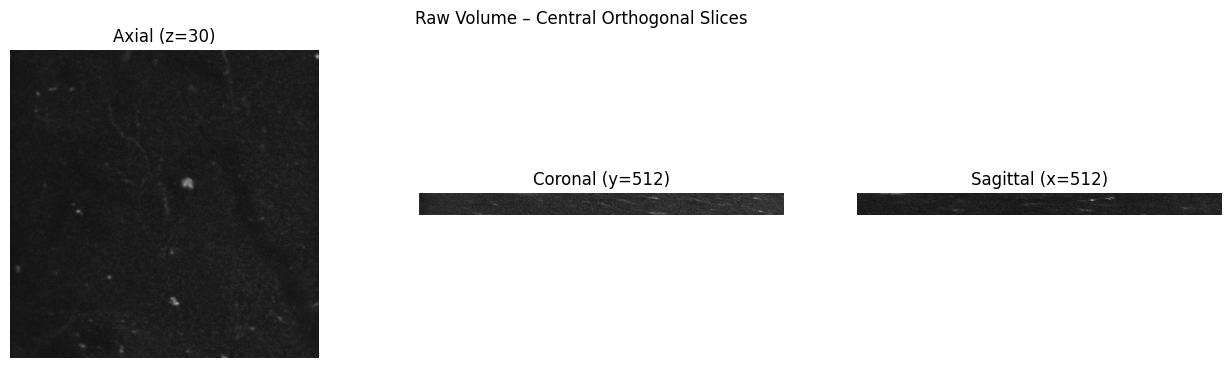

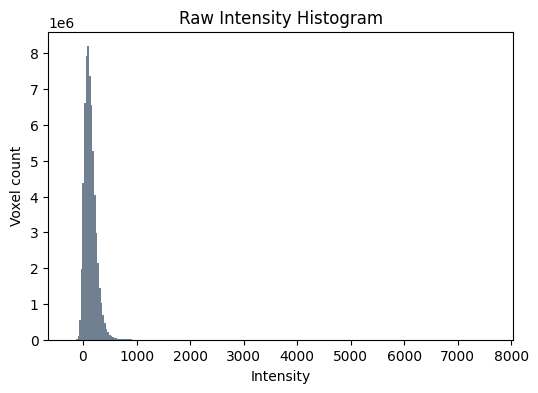

In [20]:
show_volume_slices(raw_volume, title="Raw Volume – Central Orthogonal Slices", slice_indices=CENTRAL_SLICES)

plt.figure(figsize=(6, 4))
plt.hist(raw_volume.ravel(), bins=256, color="slategray")
plt.title("Raw Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Voxel count")
plt.show()



Applied 3D Gaussian smoothing with sigma=1.5


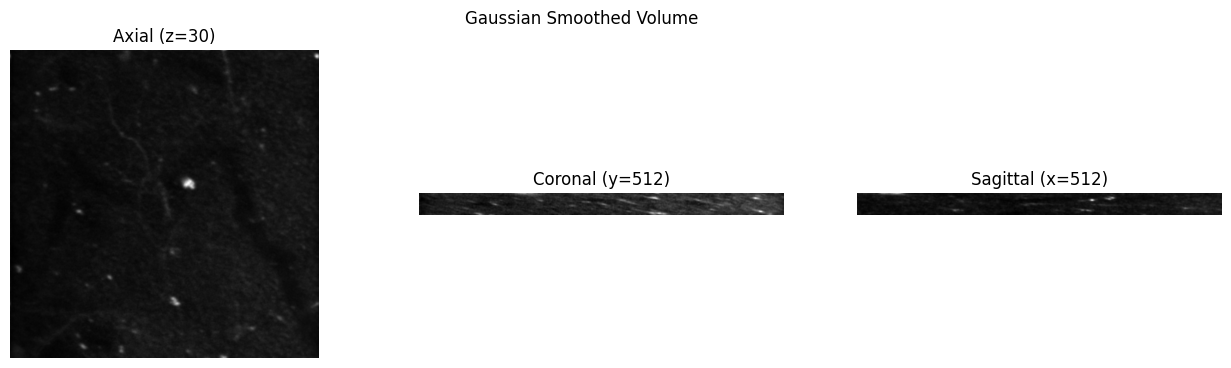

In [21]:
# --- Gaussian Smoothing ---
gaussian_sigma = 1.5
smoothed_volume = gaussian_filter(raw_volume, sigma=gaussian_sigma)

print(f"Applied 3D Gaussian smoothing with sigma={gaussian_sigma}")
show_volume_slices(smoothed_volume, title="Gaussian Smoothed Volume", slice_indices=CENTRAL_SLICES)


Applied adaptive histogram equalization with clip_limit=0.03 and kernel_size=(32, 32, 8)


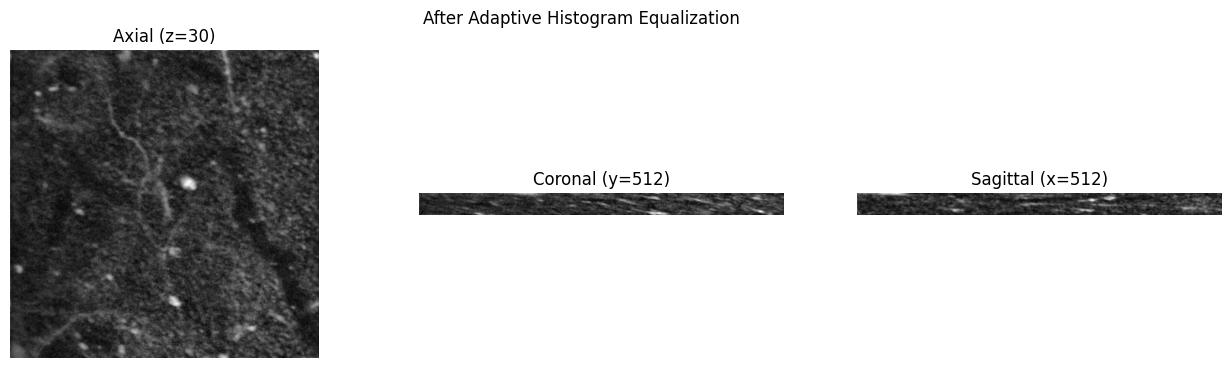

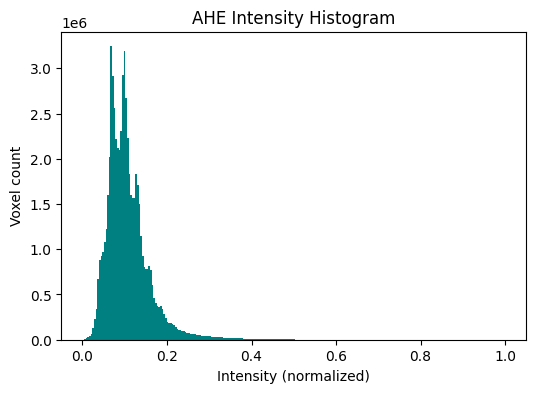

In [22]:
# --- Adaptive Histogram Equalization (optional contrast enhancement) ---
clip_limit = 0.03
kernel_size = (32, 32, 8)  # (z, y, x) neighborhood sizes

smoothed_rescaled = exposure.rescale_intensity(smoothed_volume, in_range="image")
ahe_volume = exposure.equalize_adapthist(smoothed_rescaled, kernel_size=kernel_size, clip_limit=clip_limit)

print(f"Applied adaptive histogram equalization with clip_limit={clip_limit} and kernel_size={kernel_size}")
show_volume_slices(ahe_volume, title="After Adaptive Histogram Equalization", slice_indices=CENTRAL_SLICES)

plt.figure(figsize=(6, 4))
plt.hist(ahe_volume.ravel(), bins=256, color="teal")
plt.title("AHE Intensity Histogram")
plt.xlabel("Intensity (normalized)")
plt.ylabel("Voxel count")
plt.show()


In [ ]:
# --- Multi-level intensity masking (3 peaks) ---
num_intensity_classes = 6

  # adjust if histogram shows more/less modes
multiotsu_thresholds = filters.threshold_multiotsu(ahe_volume, classes=num_intensity_classes)
print(f"Multi-Otsu thresholds: {multiotsu_thresholds}")

# Digitize intensities into class labels (0 ... num_intensity_classes-1)
intensity_labels = np.digitize(ahe_volume, bins=multiotsu_thresholds)

show_multiclass_overlay(
    ahe_volume,
    intensity_labels,
    title="Multi-Otsu Intensity Regions",
    slice_indices=CENTRAL_SLICES,
    colors=["black", "gold", "deepskyblue", "magenta"],
)

# Visualize histogram with threshold markers
plt.figure(figsize=(6, 4))
plt.hist(ahe_volume.ravel(), bins=256, color="navy", alpha=0.6)
for thresh in multiotsu_thresholds:
    plt.axvline(thresh, color="crimson", linestyle="--", linewidth=1.5)
plt.title("AHE Histogram with Multi-Otsu Cuts")
plt.xlabel("Intensity (normalized)")
plt.ylabel("Voxel count")
plt.show()

# Inspect each class mask with contours
class_bounds = [ahe_volume.min()] + list(multiotsu_thresholds) + [ahe_volume.max()]
for class_id in range(num_intensity_classes):
    lower, upper = class_bounds[class_id], class_bounds[class_id + 1]
    class_mask = intensity_labels == class_id
    show_binary_overlay(
        ahe_volume,
        class_mask,
        title=f"Class {class_id}: intensities in [{lower:.3f}, {upper:.3f})",
        slice_indices=CENTRAL_SLICES,
    )


Adaptive thresholding complete (block_size=51, offset=-0.01).


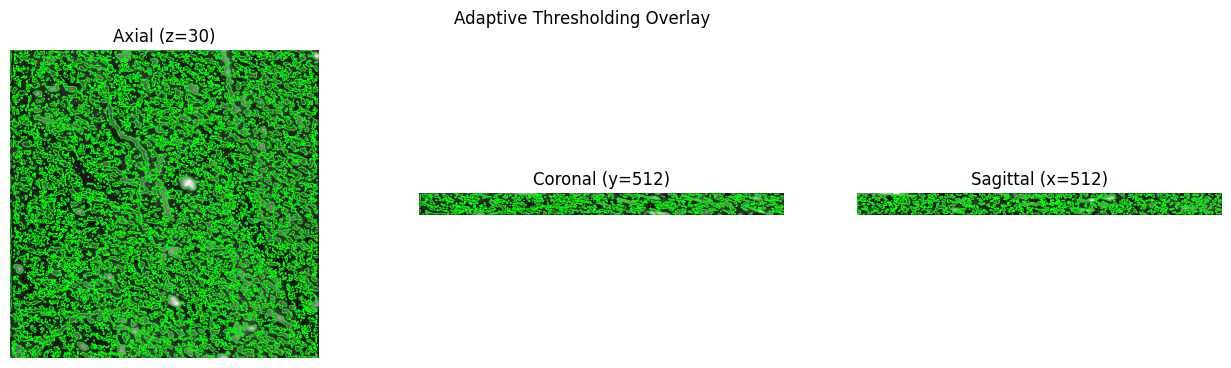

In [24]:
# --- Adaptive Thresholding ---
block_size = 51  # must be odd; maps to roughly 51x51 neighborhood per slice
offset = -0.01   # tweak to bias threshold (negative -> more voxels classified as foreground)

# Apply 2D adaptive threshold on each axial slice
adaptive_mask = np.zeros_like(ahe_volume, dtype=bool)
for z_idx in range(ahe_volume.shape[0]):
    slice_img = ahe_volume[z_idx]
    local_thresh = filters.threshold_local(slice_img, block_size=block_size, method="gaussian", offset=offset)
    adaptive_mask[z_idx] = slice_img > local_thresh

print(f"Adaptive thresholding complete (block_size={block_size}, offset={offset}).")
show_binary_overlay(ahe_volume, adaptive_mask, title="Adaptive Thresholding Overlay", slice_indices=CENTRAL_SLICES)


In [25]:
# --- Optional: Persist intermediate results ---
# OUTPUT_DIR = Path("artifacts/week1")
# OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# np.save(OUTPUT_DIR / "raw_volume.npy", raw_volume)
# np.save(OUTPUT_DIR / "smoothed_sigma1p5.npy", smoothed_volume)
# np.save(OUTPUT_DIR / "ahe_volume.npy", ahe_volume)
# np.save(OUTPUT_DIR / "adaptive_mask.npy", adaptive_mask)

# print(f"Saved intermediate arrays to {OUTPUT_DIR.resolve()}")
